In [1]:
import pandas as pd
import numpy as np
import logging
import time 
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, random_split

from scipy.spatial import distance

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tqdm import tqdm
import pickle

/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.default_rng(seed=42)
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [3]:
train_ma = pd.read_pickle("/mnt/workspace/pratheek/data/pickle/paired_embedded_train_data_biolincc_CS_mesa_aric.pkl")
train_af = pd.read_pickle("/mnt/workspace/pratheek/data/pickle/paired_embedded_train_data_biolincc_CS_aric_framingham.pkl")
train_fm = pd.read_pickle("/mnt/workspace/pratheek/data/pickle/paired_embedded_train_data_biolincc_CS_framingham_mesa.pkl")
test = pd.read_pickle("/mnt/workspace/pratheek/data/pickle/paired_embedded_test_data_biolincc.pkl")

In [4]:
print(train_ma.shape, train_af.shape, train_fm.shape, test.shape)

(17712, 10) (34378, 10) (16810, 10) (11890, 10)


### Dataset Creation

In [5]:
tr_ma_input1 = torch.tensor([x[0].numpy() for x in train_ma[['biobert_embedding_1']].to_numpy()])
tr_af_input1 = torch.tensor([x[0].numpy() for x in train_af[['biobert_embedding_1']].to_numpy()])
tr_fm_input1 = torch.tensor([x[0].numpy() for x in train_fm[['biobert_embedding_1']].to_numpy()])

tr_ma_input2 = torch.tensor([x[0].numpy() for x in train_ma[['biobert_embedding_2']].to_numpy()])
tr_af_input2 = torch.tensor([x[0].numpy() for x in train_af[['biobert_embedding_2']].to_numpy()])
tr_fm_input2 = torch.tensor([x[0].numpy() for x in train_fm[['biobert_embedding_2']].to_numpy()])

tr_ma_targets = torch.tensor([x for x in train_ma[['match']].to_numpy()]).to(torch.float32)
tr_af_targets = torch.tensor([x for x in train_af[['match']].to_numpy()]).to(torch.float32)
tr_fm_targets = torch.tensor([x for x in train_fm[['match']].to_numpy()]).to(torch.float32)

tr_ma_idx = torch.tensor([x for x in train_ma[['idx']].to_numpy()])
tr_af_idx = torch.tensor([x for x in train_af[['idx']].to_numpy()])
tr_fm_idx = torch.tensor([x for x in train_fm[['idx']].to_numpy()])

batch_size = 5000

te_input1 = torch.tensor([x[0].numpy() for x in test[['biobert_embedding_1']].to_numpy()])
te_input2 = torch.tensor([x[0].numpy() for x in test[['biobert_embedding_2']].to_numpy()])
te_targets = torch.tensor([x for x in test[['match']].to_numpy()]).to(torch.float32)
te_idx = torch.tensor([x for x in test[['idx']].to_numpy()])

tr_ma_dataset = TensorDataset(tr_ma_idx, tr_ma_input1, tr_ma_input2, tr_ma_targets)
tr_af_dataset = TensorDataset(tr_af_idx, tr_af_input1, tr_af_input2, tr_af_targets)
tr_fm_dataset = TensorDataset(tr_fm_idx, tr_fm_input1, tr_fm_input2, tr_fm_targets)

te_dataset = TensorDataset(te_idx, te_input1, te_input2, te_targets)

train_ma_data, val_ma_data = random_split(tr_ma_dataset, [14170, 3542])
train_af_data, val_af_data = random_split(tr_af_dataset, [27502, 6876])
train_fm_data, val_fm_data = random_split(tr_fm_dataset, [13448, 3362])

test_data, _ = random_split(te_dataset, [11880, 10])

train_ma_loader = DataLoader(train_ma_data, batch_size)
train_af_loader = DataLoader(train_af_data, batch_size)
train_fm_loader = DataLoader(train_fm_data, batch_size)

val_ma_loader = DataLoader(val_ma_data, batch_size)
val_af_loader = DataLoader(val_af_data, batch_size)
val_fm_loader = DataLoader(val_fm_data, batch_size)

test_loader = DataLoader(test_data, batch_size)

/usr/bin/anaconda3/envs/duke/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  """Entry point for launching an IPython kernel.


### Model Creation

In [6]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        
        self.first_layer = nn.Linear(768, 256) 
        # also add a dropout layer (10%) after initial tests without
        self.relu = nn.ReLU()
        self.second_layer = nn.Linear(256, 128)
        self.cosine = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.sigmoid = nn.Sigmoid()
        self.bias = nn.Parameter(torch.rand(1, 1))

    def forward(self, inp1, inp2):
        hidden_first_1 = self.first_layer(inp1)
        hidden_first_2 = self.first_layer(inp2)
        hidden_second_1 = self.second_layer(self.relu(hidden_first_1))
        hidden_second_2 = self.second_layer(self.relu(hidden_first_2))
        similarity = self.cosine(hidden_second_1, hidden_second_2) + self.bias
        output = self.sigmoid(similarity)
        return output.T

In [7]:
model_ma = FCN()
model_af = FCN()
model_fm = FCN()

### Training

In [8]:
# init loss lists
train_loss_history = []
val_loss_history = []

In [9]:
# init index trackers
train_idx_tracker = []
val_idx_tracker = []

In [10]:
# set training hyperparameters
num_epochs = 500
patience = 5
min_val_delta = 0

In [11]:
if torch.cuda.is_available():
    model_ma = model_ma.to('cuda')

model_ma.train()

criterion = nn.BCELoss()
optimizer = optim.Adam(model_ma.parameters())
early_stopping_counter = 0
min_val_loss = np.inf

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_val_loss = 0
    
    # compute train loss for epoch and step through
    for batch in train_ma_loader:
        optimizer.zero_grad()
        
        idx, inp1, inp2, label = batch
        train_idx_tracker.append(idx.cpu().squeeze().detach().numpy())
        
        if torch.cuda.is_available():
            inp1 = inp1.to('cuda')
            inp2 = inp2.to('cuda')
            label = label.to('cuda')

        output = model_ma(inp1, inp2)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.cpu().item()
    
    # compute val loss for epoch
    with torch.no_grad():
        for val_batch in val_ma_loader:
                val_idx, val_inp1, val_inp2, val_label = val_batch
                val_idx_tracker.append(val_idx.cpu().squeeze().detach().numpy())
                
                if torch.cuda.is_available():
                    val_inp1 = val_inp1.to('cuda')
                    val_inp2 = val_inp2.to('cuda')
                    val_label = val_label.to('cuda')

                val_output = model_ma(val_inp1, val_inp2)
                val_loss = criterion(val_output, val_label)
                epoch_val_loss += val_loss.cpu().item()
    
    # print to log
    if (epoch % 20 == 0) and (epoch >= 20):
        print("Epoch %d \t Train Loss %.6f \t Val Loss %.6f" % (epoch, epoch_loss, epoch_val_loss))
    elif (epoch % 5 == 0) and (epoch < 20):
        print("Epoch %d \t Train Loss %.6f \t Val Loss %.6f" % (epoch, epoch_loss, epoch_val_loss))
    
    # add loss to histories
    train_loss_history.append(epoch_loss)
    val_loss_history.append(epoch_val_loss)
    
    # set early stopping
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        early_stopping_counter = 0
    elif epoch_val_loss > (min_val_loss + min_val_delta):
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Initiating early stopping at epoch %d." % (epoch))
            break

Epoch 0 	 Train Loss 2.519536 	 Val Loss 0.652688
Epoch 5 	 Train Loss 1.753511 	 Val Loss 0.591336
Epoch 10 	 Train Loss 1.684165 	 Val Loss 0.571830
Epoch 15 	 Train Loss 1.651364 	 Val Loss 0.564907
Epoch 20 	 Train Loss 1.629190 	 Val Loss 0.559757
Epoch 40 	 Train Loss 1.566045 	 Val Loss 0.542770
Epoch 60 	 Train Loss 1.520468 	 Val Loss 0.530560
Epoch 80 	 Train Loss 1.483352 	 Val Loss 0.520103
Epoch 100 	 Train Loss 1.451586 	 Val Loss 0.510249
Epoch 120 	 Train Loss 1.423391 	 Val Loss 0.501171
Epoch 140 	 Train Loss 1.398780 	 Val Loss 0.492733
Epoch 160 	 Train Loss 1.376682 	 Val Loss 0.484548
Epoch 180 	 Train Loss 1.357173 	 Val Loss 0.476998
Epoch 200 	 Train Loss 1.339675 	 Val Loss 0.470233
Epoch 220 	 Train Loss 1.324390 	 Val Loss 0.464183
Epoch 240 	 Train Loss 1.310698 	 Val Loss 0.458873
Epoch 260 	 Train Loss 1.298928 	 Val Loss 0.453929
Epoch 280 	 Train Loss 1.288550 	 Val Loss 0.449506
Epoch 300 	 Train Loss 1.279274 	 Val Loss 0.445633
Epoch 320 	 Train Loss

<AxesSubplot:>

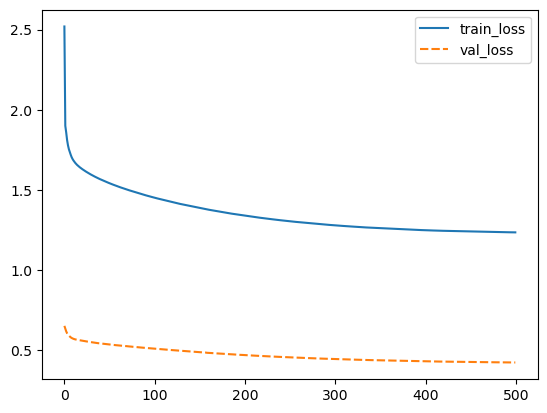

In [12]:
# plot the train and val losses
loss_history = pd.DataFrame({
    "train_loss": train_loss_history,
    "val_loss": val_loss_history
})
sns.lineplot(data=loss_history)

In [13]:
# save model state_dict
torch.save(model_ma.state_dict(), '/mnt/workspace/pratheek/models/saved/model1_biolincc_cohort_spec_ma.pth')

In [14]:
# init loss lists
train_loss_history = []
val_loss_history = []

# init index trackers
train_idx_tracker = []
val_idx_tracker = []

# set training hyperparameters
num_epochs = 500
patience = 5
min_val_delta = 0

In [15]:
if torch.cuda.is_available():
    model_af = model_af.to('cuda')

model_af.train()

criterion = nn.BCELoss()
optimizer = optim.Adam(model_af.parameters())
early_stopping_counter = 0
min_val_loss = np.inf

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_val_loss = 0
    
    # compute train loss for epoch and step through
    for batch in train_af_loader:
        optimizer.zero_grad()
        
        idx, inp1, inp2, label = batch
        train_idx_tracker.append(idx.cpu().squeeze().detach().numpy())
        
        if torch.cuda.is_available():
            inp1 = inp1.to('cuda')
            inp2 = inp2.to('cuda')
            label = label.to('cuda')

        output = model_af(inp1, inp2)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.cpu().item()
    
    # compute val loss for epoch
    with torch.no_grad():
        for val_batch in val_af_loader:
                val_idx, val_inp1, val_inp2, val_label = val_batch
                val_idx_tracker.append(val_idx.cpu().squeeze().detach().numpy())
                
                if torch.cuda.is_available():
                    val_inp1 = val_inp1.to('cuda')
                    val_inp2 = val_inp2.to('cuda')
                    val_label = val_label.to('cuda')

                val_output = model_af(val_inp1, val_inp2)
                val_loss = criterion(val_output, val_label)
                epoch_val_loss += val_loss.cpu().item()
    
    # print to log
    if (epoch % 20 == 0) and (epoch >= 20):
        print("Epoch %d \t Train Loss %.6f \t Val Loss %.6f" % (epoch, epoch_loss, epoch_val_loss))
    elif (epoch % 5 == 0) and (epoch < 20):
        print("Epoch %d \t Train Loss %.6f \t Val Loss %.6f" % (epoch, epoch_loss, epoch_val_loss))
    
    # add loss to histories
    train_loss_history.append(epoch_loss)
    val_loss_history.append(epoch_val_loss)
    
    # set early stopping
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        early_stopping_counter = 0
    elif epoch_val_loss > (min_val_loss + min_val_delta):
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Initiating early stopping at epoch %d." % (epoch))
            break

Epoch 0 	 Train Loss 5.263774 	 Val Loss 1.520825
Epoch 5 	 Train Loss 4.187750 	 Val Loss 1.399534
Epoch 10 	 Train Loss 4.076913 	 Val Loss 1.371238
Epoch 15 	 Train Loss 3.988674 	 Val Loss 1.346945
Epoch 20 	 Train Loss 3.915006 	 Val Loss 1.326565
Epoch 40 	 Train Loss 3.670906 	 Val Loss 1.256717
Epoch 60 	 Train Loss 3.471336 	 Val Loss 1.192025
Epoch 80 	 Train Loss 3.299160 	 Val Loss 1.140111
Epoch 100 	 Train Loss 3.151136 	 Val Loss 1.089429
Epoch 120 	 Train Loss 3.024093 	 Val Loss 1.046596
Epoch 140 	 Train Loss 2.913423 	 Val Loss 1.009701
Epoch 160 	 Train Loss 2.824328 	 Val Loss 0.977135
Epoch 180 	 Train Loss 2.743854 	 Val Loss 0.949632
Epoch 200 	 Train Loss 2.679144 	 Val Loss 0.926231
Epoch 220 	 Train Loss 2.626750 	 Val Loss 0.906692
Epoch 240 	 Train Loss 2.582936 	 Val Loss 0.891210
Epoch 260 	 Train Loss 2.545708 	 Val Loss 0.876772
Epoch 280 	 Train Loss 2.517041 	 Val Loss 0.866203
Epoch 300 	 Train Loss 2.494402 	 Val Loss 0.857113
Epoch 320 	 Train Loss

<AxesSubplot:>

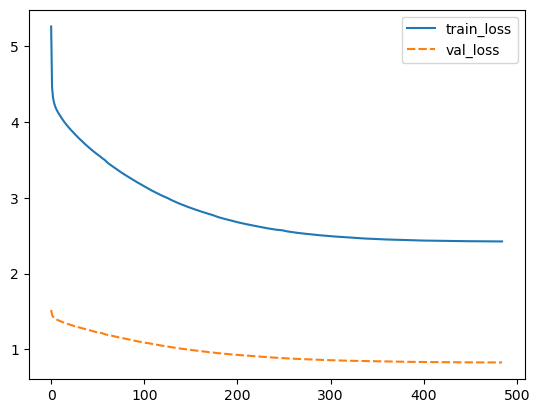

In [16]:
# plot the train and val losses
loss_history = pd.DataFrame({
    "train_loss": train_loss_history,
    "val_loss": val_loss_history
})
sns.lineplot(data=loss_history)

In [17]:
# save model state_dict
torch.save(model_af.state_dict(), '/mnt/workspace/pratheek/models/saved/model1_biolincc_cohort_spec_af.pth')

In [18]:
# init loss lists
train_loss_history = []
val_loss_history = []

# init index trackers
train_idx_tracker = []
val_idx_tracker = []

# set training hyperparameters
num_epochs = 500
patience = 5
min_val_delta = 0

In [19]:
if torch.cuda.is_available():
    model_fm = model_fm.to('cuda')

model_fm.train()

criterion = nn.BCELoss()
optimizer = optim.Adam(model_fm.parameters())
early_stopping_counter = 0
min_val_loss = np.inf

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_val_loss = 0
    
    # compute train loss for epoch and step through
    for batch in train_fm_loader:
        optimizer.zero_grad()
        
        idx, inp1, inp2, label = batch
        train_idx_tracker.append(idx.cpu().squeeze().detach().numpy())
        
        if torch.cuda.is_available():
            inp1 = inp1.to('cuda')
            inp2 = inp2.to('cuda')
            label = label.to('cuda')

        output = model_fm(inp1, inp2)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.cpu().item()
    
    # compute val loss for epoch
    with torch.no_grad():
        for val_batch in val_fm_loader:
                val_idx, val_inp1, val_inp2, val_label = val_batch
                val_idx_tracker.append(val_idx.cpu().squeeze().detach().numpy())
                
                if torch.cuda.is_available():
                    val_inp1 = val_inp1.to('cuda')
                    val_inp2 = val_inp2.to('cuda')
                    val_label = val_label.to('cuda')

                val_output = model_fm(val_inp1, val_inp2)
                val_loss = criterion(val_output, val_label)
                epoch_val_loss += val_loss.cpu().item()
    
    # print to log
    if (epoch % 20 == 0) and (epoch >= 20):
        print("Epoch %d \t Train Loss %.6f \t Val Loss %.6f" % (epoch, epoch_loss, epoch_val_loss))
    elif (epoch % 5 == 0) and (epoch < 20):
        print("Epoch %d \t Train Loss %.6f \t Val Loss %.6f" % (epoch, epoch_loss, epoch_val_loss))
    
    # add loss to histories
    train_loss_history.append(epoch_loss)
    val_loss_history.append(epoch_val_loss)
    
    # set early stopping
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        early_stopping_counter = 0
    elif epoch_val_loss > (min_val_loss + min_val_delta):
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Initiating early stopping at epoch %d." % (epoch))
            break

Epoch 0 	 Train Loss 2.873258 	 Val Loss 0.785529
Epoch 5 	 Train Loss 2.146229 	 Val Loss 0.713140
Epoch 10 	 Train Loss 2.072220 	 Val Loss 0.694463
Epoch 15 	 Train Loss 2.031236 	 Val Loss 0.684872
Epoch 20 	 Train Loss 2.001550 	 Val Loss 0.677810
Epoch 40 	 Train Loss 1.912595 	 Val Loss 0.659177
Epoch 60 	 Train Loss 1.845189 	 Val Loss 0.643732
Epoch 80 	 Train Loss 1.788813 	 Val Loss 0.628938
Epoch 100 	 Train Loss 1.737804 	 Val Loss 0.614173
Epoch 120 	 Train Loss 1.691378 	 Val Loss 0.599372
Epoch 140 	 Train Loss 1.650380 	 Val Loss 0.585651
Epoch 160 	 Train Loss 1.610471 	 Val Loss 0.572126
Epoch 180 	 Train Loss 1.574698 	 Val Loss 0.559412
Epoch 200 	 Train Loss 1.541722 	 Val Loss 0.547756
Epoch 220 	 Train Loss 1.509875 	 Val Loss 0.536205
Epoch 240 	 Train Loss 1.481818 	 Val Loss 0.525629
Epoch 260 	 Train Loss 1.454646 	 Val Loss 0.516005
Epoch 280 	 Train Loss 1.430477 	 Val Loss 0.506250
Epoch 300 	 Train Loss 1.408029 	 Val Loss 0.497766
Epoch 320 	 Train Loss

<AxesSubplot:>

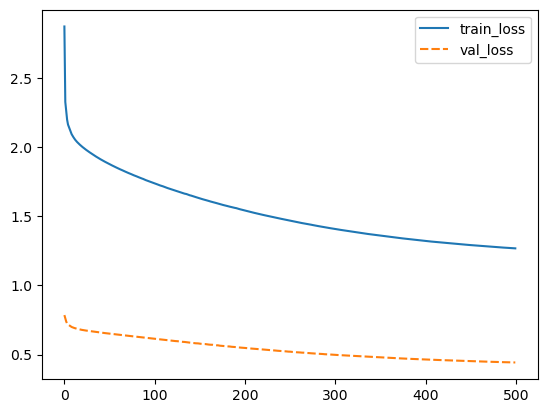

In [20]:
# plot the train and val losses
loss_history = pd.DataFrame({
    "train_loss": train_loss_history,
    "val_loss": val_loss_history
})
sns.lineplot(data=loss_history)

In [21]:
# save model state_dict
torch.save(model_fm.state_dict(), '/mnt/workspace/pratheek/models/saved/model1_biolincc_cohort_spec_fm.pth')

### Inference

In [8]:
inf_ma_model = FCN()
inf_af_model = FCN()
inf_fm_model = FCN()

inf_ma_model.load_state_dict(torch.load('/mnt/workspace/pratheek/models/saved/model1_biolincc_cohort_spec_ma.pth'))
inf_af_model.load_state_dict(torch.load('/mnt/workspace/pratheek/models/saved/model1_biolincc_cohort_spec_af.pth'))
inf_fm_model.load_state_dict(torch.load('/mnt/workspace/pratheek/models/saved/model1_biolincc_cohort_spec_fm.pth'))

if torch.cuda.is_available():
    inf_ma_model = inf_ma_model.to('cuda')
    inf_af_model = inf_af_model.to('cuda')
    inf_fm_model = inf_fm_model.to('cuda')
    
inf_ma_model.eval()
inf_af_model.eval()
inf_fm_model.eval()

FCN(
  (first_layer): Linear(in_features=768, out_features=256, bias=True)
  (relu): ReLU()
  (second_layer): Linear(in_features=256, out_features=128, bias=True)
  (cosine): CosineSimilarity()
  (sigmoid): Sigmoid()
)

In [9]:
outputs_ma = []
labels_ma = []
idxs_ma = []

for batch in test_loader:
    idx, inp1, inp2, label = batch
    idx = idx.cpu().squeeze().detach().numpy()
    idxs_ma.append(idx)
    
    if torch.cuda.is_available():
        inp1 = inp1.to('cuda')
        inp2 = inp2.to('cuda')
        label = label.to('cuda')

    output = inf_ma_model(inp1, inp2)
    
    output = output.cpu().squeeze().detach().numpy()
    outputs_ma.append(output)
    label = label.cpu().squeeze().detach().numpy()
    labels_ma.append(label)

idxs_ma = np.concatenate(idxs_ma).ravel()
outputs_ma = np.concatenate(outputs_ma).ravel()
labels_ma = np.concatenate(labels_ma).ravel()

In [10]:
outputs_af = []
labels_af = []
idxs_af = []

for batch in test_loader:
    idx, inp1, inp2, label = batch
    idx = idx.cpu().squeeze().detach().numpy()
    idxs_af.append(idx)
    
    if torch.cuda.is_available():
        inp1 = inp1.to('cuda')
        inp2 = inp2.to('cuda')
        label = label.to('cuda')

    output = inf_af_model(inp1, inp2)
    
    output = output.cpu().squeeze().detach().numpy()
    outputs_af.append(output)
    label = label.cpu().squeeze().detach().numpy()
    labels_af.append(label)

idxs_af = np.concatenate(idxs_af).ravel()
outputs_af = np.concatenate(outputs_af).ravel()
labels_af = np.concatenate(labels_af).ravel()

In [11]:
outputs_fm = []
labels_fm = []
idxs_fm = []

for batch in test_loader:
    idx, inp1, inp2, label = batch
    idx = idx.cpu().squeeze().detach().numpy()
    idxs_fm.append(idx)
    
    if torch.cuda.is_available():
        inp1 = inp1.to('cuda')
        inp2 = inp2.to('cuda')
        label = label.to('cuda')

    output = inf_fm_model(inp1, inp2)
    
    output = output.cpu().squeeze().detach().numpy()
    outputs_fm.append(output)
    label = label.cpu().squeeze().detach().numpy()
    labels_fm.append(label)

idxs_fm = np.concatenate(idxs_fm).ravel()
outputs_fm = np.concatenate(outputs_fm).ravel()
labels_fm = np.concatenate(labels_fm).ravel()

In [12]:
idxs_fm

array([40167, 27502, 43894, ..., 19214,  6257, 16593])

In [13]:
idxs_ma

array([40167, 27502, 43894, ..., 19214,  6257, 16593])

In [14]:
idxs_af

array([40167, 27502, 43894, ..., 19214,  6257, 16593])

In [15]:
outputs_ma

array([0.20105982, 0.31535652, 0.20819058, ..., 0.37866458, 0.55578244,
       0.27837628], dtype=float32)

In [16]:
outputs_af

array([0.18635134, 0.2528148 , 0.21312428, ..., 0.17889893, 0.479675  ,
       0.21862553], dtype=float32)

In [17]:
outputs_fm

array([0.34562546, 0.2503648 , 0.27500314, ..., 0.28709427, 0.40719533,
       0.24848986], dtype=float32)

In [18]:
labels_ma

array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [19]:
labels_af

array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [20]:
labels_fm

array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [21]:
print(sum(idxs_fm == idxs_ma), len(idxs_fm))

11880 11880


In [22]:
with open('./visualization/fcn_preds_cohort_spec_ma.pkl', 'wb') as wfile:
    pickle.dump(outputs_ma, wfile)
with open('./visualization/fcn_preds_cohort_spec_af.pkl', 'wb') as wfile:
    pickle.dump(outputs_af, wfile)
with open('./visualization/fcn_preds_cohort_spec_fm.pkl', 'wb') as wfile:
    pickle.dump(outputs_fm, wfile)
with open('./visualization/fcn_gt_labels_cohort_spec.pkl', 'wb') as wfile:
    pickle.dump(labels_af, wfile)

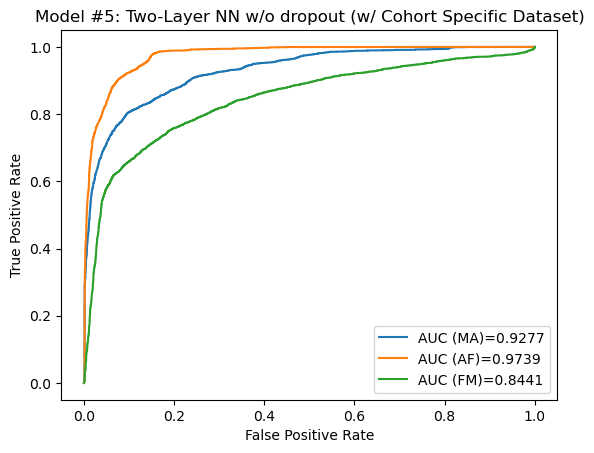

In [23]:
from sklearn import metrics

fpr_ma, tpr_ma, _ = metrics.roc_curve(labels_ma, outputs_ma)
fpr_af, tpr_af, _ = metrics.roc_curve(labels_af, outputs_af)
fpr_fm, tpr_fm, _ = metrics.roc_curve(labels_fm, outputs_fm)

auc_ma = metrics.roc_auc_score(labels_ma, outputs_ma)
auc_af = metrics.roc_auc_score(labels_af, outputs_af)
auc_fm = metrics.roc_auc_score(labels_fm, outputs_fm)

plt.plot(fpr_ma, tpr_ma, label="AUC (MA)="+str(np.round(auc_ma, 4)))
plt.plot(fpr_af, tpr_af, label="AUC (AF)="+str(np.round(auc_af, 4)))
plt.plot(fpr_fm, tpr_fm, label="AUC (FM)="+str(np.round(auc_fm, 4)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Model #5: Two-Layer NN w/o dropout (w/ Cohort Specific Dataset)')
plt.legend(loc=4)
plt.show()

In [24]:
inf_df = test[test['idx'].isin(idxs_ma)]
inf_preds = pd.DataFrame({
    "idx": idxs_ma,
    "match": labels_ma,
    "predict_proba_ma": outputs_ma,
    "predict_proba_af": outputs_af,
    "predict_proba_fm": outputs_fm
})
inf_df = inf_df.merge(inf_preds, on=['idx', 'match'], how='inner')
inf_df.shape

(11880, 13)

In [25]:
inf_df_m = inf_df[(inf_df['study_1'] == 'MESA') & (inf_df['study_2'] == 'MESA')]
inf_df_a = inf_df[(inf_df['study_1'] == 'ARIC') & (inf_df['study_2'] == 'ARIC')]
inf_df_f = inf_df[(inf_df['study_1'] == 'Framingham') & (inf_df['study_2'] == 'Framingham')]
print(inf_df_m.shape, inf_df_a.shape, inf_df_f.shape)

(331, 13) (2244, 13) (2029, 13)


In [26]:
outputs_ma_excl = inf_df_f['predict_proba_ma'].to_list()
labels_ma_excl = inf_df_f['match'].to_list()
outputs_af_excl = inf_df_m['predict_proba_af'].to_list()
labels_af_excl = inf_df_m['match'].to_list()
outputs_fm_excl = inf_df_a['predict_proba_fm'].to_list()
labels_fm_excl = inf_df_a['match'].to_list()

In [27]:
with open('./visualization/fcn_preds_cohort_spec_ma_excl.pkl', 'wb') as wfile:
    pickle.dump(outputs_ma_excl, wfile)
with open('./visualization/fcn_gt_labels_cohort_spec_ma_excl.pkl', 'wb') as wfile:
    pickle.dump(labels_ma_excl, wfile)
with open('./visualization/fcn_preds_cohort_spec_af_excl.pkl', 'wb') as wfile:
    pickle.dump(outputs_af_excl, wfile)
with open('./visualization/fcn_gt_labels_cohort_spec_af_excl.pkl', 'wb') as wfile:
    pickle.dump(labels_af_excl, wfile)
with open('./visualization/fcn_preds_cohort_spec_fm_excl.pkl', 'wb') as wfile:
    pickle.dump(outputs_fm_excl, wfile)
with open('./visualization/fcn_gt_labels_cohort_spec_fm_excl.pkl', 'wb') as wfile:
    pickle.dump(labels_fm_excl, wfile)

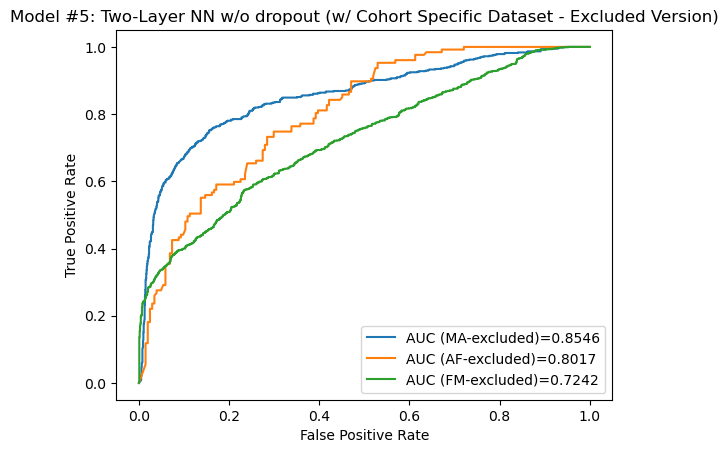

In [28]:
fpr_ma_excl, tpr_ma_excl, _ = metrics.roc_curve(labels_ma_excl, outputs_ma_excl)
fpr_af_excl, tpr_af_excl, _ = metrics.roc_curve(labels_af_excl, outputs_af_excl)
fpr_fm_excl, tpr_fm_excl, _ = metrics.roc_curve(labels_fm_excl, outputs_fm_excl)

auc_ma_excl = metrics.roc_auc_score(labels_ma_excl, outputs_ma_excl)
auc_af_excl = metrics.roc_auc_score(labels_af_excl, outputs_af_excl)
auc_fm_excl = metrics.roc_auc_score(labels_fm_excl, outputs_fm_excl)

plt.plot(fpr_ma_excl, tpr_ma_excl, label="AUC (MA-excluded)="+str(np.round(auc_ma_excl, 4)))
plt.plot(fpr_af_excl, tpr_af_excl, label="AUC (AF-excluded)="+str(np.round(auc_af_excl, 4)))
plt.plot(fpr_fm_excl, tpr_fm_excl, label="AUC (FM-excluded)="+str(np.round(auc_fm_excl, 4)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Model #5: Two-Layer NN w/o dropout (w/ Cohort Specific Dataset - Excluded Version)')
plt.legend(loc=4)
plt.show()

In [29]:
# per-concept AUC
concepts = inf_df.concept_name_1.unique()
mauc_ovr = {}
for concept in concepts:
    print("------------------------")
    
    inf_df_concept = inf_df[(inf_df['concept_name_1'] == concept) | (inf_df['concept_name_2'] == concept)]
    print(concept, ": ", inf_df_concept.shape[0])
    
    preds = inf_df_concept[['predict_proba_ma', 'predict_proba_af', 'predict_proba_fm']].mean(axis=1).to_list()

    gt_labels = inf_df_concept.match.to_list()
    
    if len(inf_df_concept.match.unique()) == 1:
        print("Only single class present")
        continue
    fpr, tpr, _ = metrics.roc_curve(gt_labels, preds)
    mauc_ovr[concept] = metrics.roc_auc_score(gt_labels, preds)
    print("AUC for", concept, " : ", mauc_ovr[concept])

------------------------
AFIB :  318
AUC for AFIB  :  0.9314415907207954
------------------------
AGE :  321
AUC for AGE  :  0.9993031358885017
------------------------
ALCOHOL :  249
AUC for ALCOHOL  :  0.9914529914529914
------------------------
ANYCHOLMED :  1181
AUC for ANYCHOLMED  :  0.9628283053024405
------------------------
ASPIRIN :  439
AUC for ASPIRIN  :  0.8826473859844272
------------------------
BASE_CVD :  92
AUC for BASE_CVD  :  0.9666666666666667
------------------------
BASE_STROKE :  84
AUC for BASE_STROKE  :  0.9625
------------------------
BG :  136
AUC for BG  :  0.9982502187226597
------------------------
BMI :  237
AUC for BMI  :  0.9983421750663131
------------------------
CARSTEN :  115
AUC for CARSTEN  :  0.9589947089947091
------------------------
CENSDAY :  51
AUC for CENSDAY  :  0.9861111111111112
------------------------
CREAT :  183
AUC for CREAT  :  1.0
------------------------
CURRSMK :  341
AUC for CURRSMK  :  1.0
------------------------
DEATH_IND : 

In [30]:
with open('./visualization/fcn_mauc_ovr_cohort_spec.pkl', 'wb') as wfile:
    pickle.dump(mauc_ovr, wfile)

In [31]:
concept = 'AFIB'
conc_inf_df = inf_df[(inf_df['concept_name_1'] == concept) | (inf_df['concept_name_2'] == concept)][['variable_description_1', 'concept_name_1', 'variable_description_2', 'concept_name_2', 'match', 'predict_proba_ma', 'predict_proba_af', 'predict_proba_fm']]
conc_inf_df

,variable_description_1,concept_name_1,variable_description_2,concept_name_2,match,predict_proba_ma,predict_proba_af,predict_proba_fm
0,Atrial fibrillation,AFIB,time to incident af,AFIB,1,0.524022,0.475510,0.485219
1,Atrial fibrillation,AFIB,ATRIAL FIBRILLATION,AFIB,1,0.555874,0.480413,0.558878
2,Atrial fibrillation,AFIB,ECG-ATRIAL FIBRILLATION,AFIB,1,0.513584,0.469328,0.511718
3,Atrial fibrillation,AFIB,Atrial Fibrillation (via ICD10 Code): Time fro...,AFIB,1,0.524323,0.423388,0.541266
4,Atrial fibrillation,AFIB,"TIME BETWEEN FIRST AND FIFTH VISITS, IN DAYS",AFIB,1,0.473697,0.323933,0.399958
...,...,...,...,...,...,...,...,...
11681,YAMS/SWEET POTATOES:(servings/week),VEGETABLES,"Time between first and third visits, in days",AFIB,0,0.269986,0.239646,0.267052
11693,GREEN STRING BEANS OR ASPARAGUS,VEGETABLES,Atrial fibrillation,AFIB,0,0.332522,0.234757,0.227722
11737,WINTER SQUASH:(servings/week),VEGETABLES,Atrial fibrillation,AFIB,0,0.383791,0.226462,0.240425
11849,"Weight (pounds), Exam 1",WGT,ATRIAL FIBRILLATION,AFIB,0,0.453941,0.310912,0.371394


In [32]:
inf_df['predict_proba'] = inf_df[['predict_proba_ma', 'predict_proba_af', 'predict_proba_fm']].mean(axis=1)
proba_1 = inf_df.loc[inf_df['match'] == 1, 'predict_proba'].to_numpy()
proba_1.sort()
proba_0 = inf_df.loc[inf_df['match'] == 0, 'predict_proba'].to_numpy()
proba_0.sort()

In [33]:
with open('./visualization/fcn_prob_match_0_cohort_spec.pkl', 'wb') as wfile:
    pickle.dump(proba_0, wfile)
with open('./visualization/fcn_prob_match_1_cohort_spec.pkl', 'wb') as wfile:
    pickle.dump(proba_1, wfile)

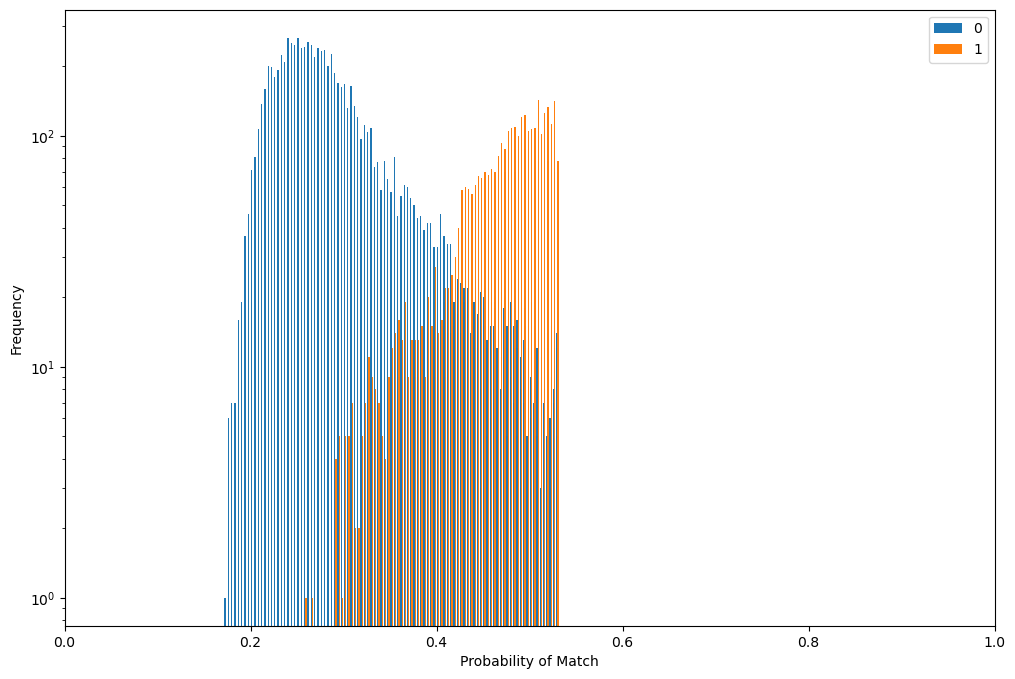

In [34]:
# plot prediction probabilities
plt.figure(figsize=(12,8))
plt.hist([proba_0, proba_1], bins=101, label=['0', '1'])
plt.legend(loc="upper right")
plt.xlabel("Probability of Match")
plt.ylabel("Frequency")
plt.xlim(0.0, 1.0)
plt.yscale('log')
plt.show()

In [35]:
violin_concepts = []
violin_match = []
violin_pred = []

In [36]:
for concept in concepts:
    match_inf_conc = inf_df[(inf_df['concept_name_1'] == concept) | (inf_df['concept_name_2'] == concept)][['concept_name_1','concept_name_2', 'match', 'predict_proba']]
    match_inf_conc['concept_name'] = match_inf_conc['concept_name_1'] + "," + match_inf_conc['concept_name_2']
    match_inf_conc['concept_name'] = match_inf_conc['concept_name'].str.split(",")
    match_inf_conc = match_inf_conc.explode('concept_name')
    match_inf_conc = match_inf_conc.drop(columns=['concept_name_1', 'concept_name_2'])
    match_inf_conc = match_inf_conc.drop_duplicates().reset_index(drop=True)
    violin_concepts.append(match_inf_conc['concept_name'].values)
    violin_match.append(match_inf_conc['match'].values)
    violin_pred.append(match_inf_conc['predict_proba'].values)

In [37]:
violin_df = pd.DataFrame({
    "concept": np.concatenate(violin_concepts).tolist(),
    "match": np.concatenate(violin_match).tolist(),
    "predict_proba": np.concatenate(violin_pred).tolist()
})
print(violin_df.shape)
violin_df = violin_df.sort_values("concept")

(37200, 3)


In [38]:
violin_df.to_pickle('./visualization/fcn_violin_df_cohort_spec.pkl')

<AxesSubplot:xlabel='predict_proba', ylabel='concept'>

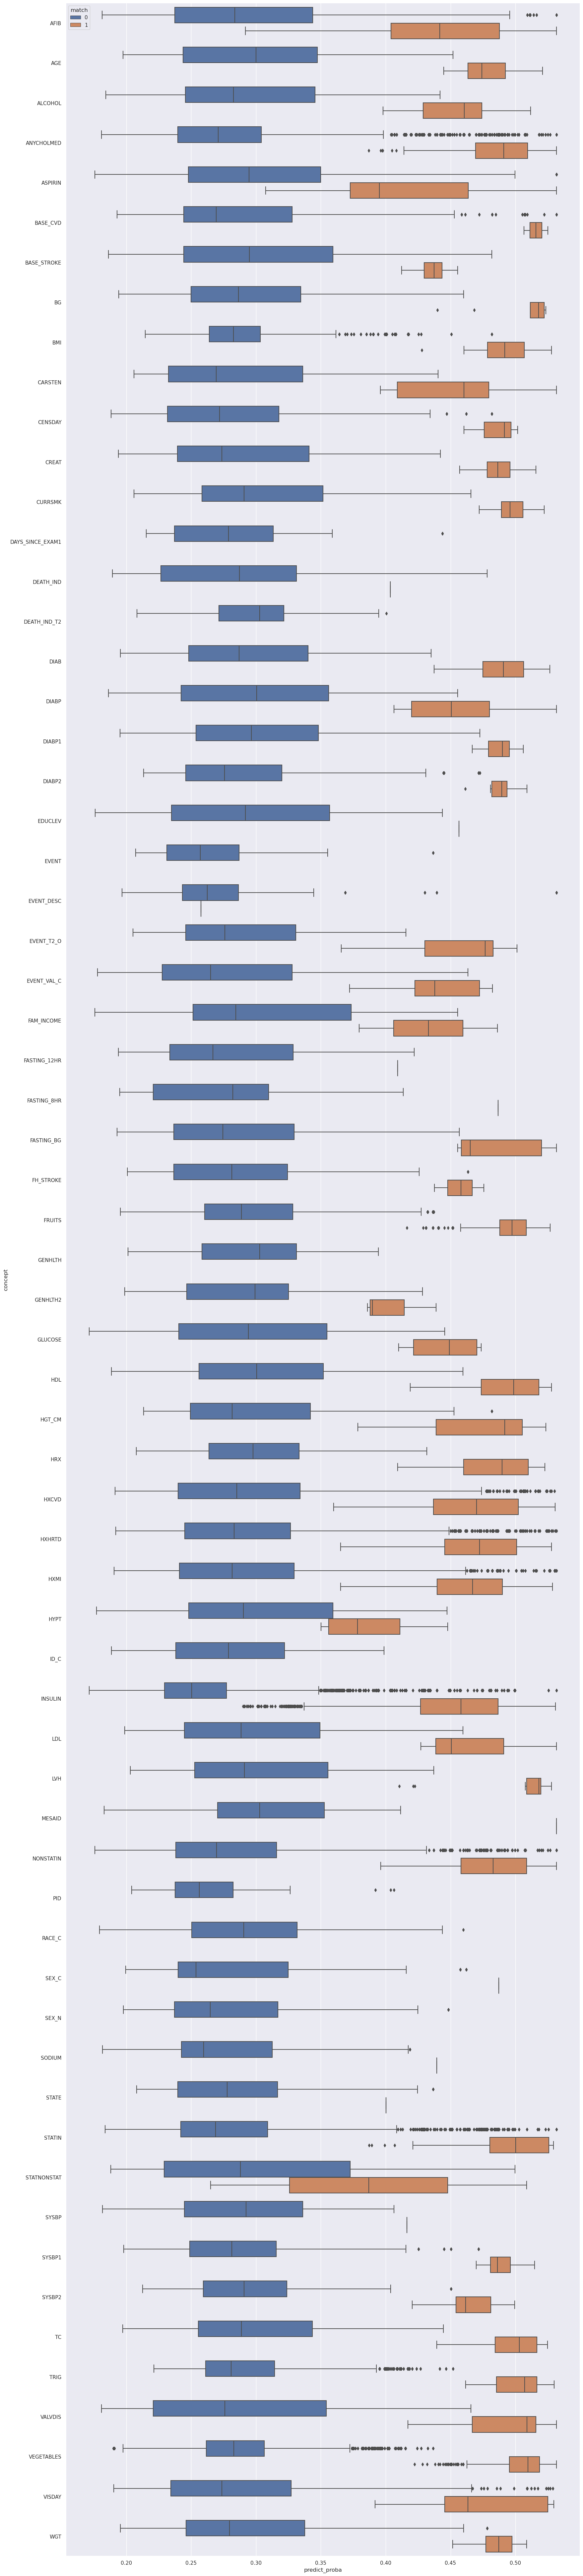

In [39]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 100)})
sns.boxplot(data=violin_df, x="predict_proba", y="concept", hue="match")

### Concept Predictor

In [40]:
df_p = pd.read_pickle("/mnt/workspace/pratheek/data/pickle/predictor_data_biolincc.pkl")
df_p = df_p.reset_index(drop=True)
df_p

,variable_description,concept,study,biobert_embedding
0,Atrial fibrillation,AFIB,ARIC,"[tensor(0.1640), tensor(0.1292), tensor(0.2356..."
1,Incident AF,AFIB,ARIC,"[tensor(-0.0823), tensor(-0.1281), tensor(-0.3..."
2,time to incident af,AFIB,ARIC,"[tensor(0.2017), tensor(-0.1166), tensor(-0.38..."
3,DAYS SINCE EXAM 1,AFIB,ARIC,"[tensor(0.4667), tensor(-0.3528), tensor(-0.15..."
4,ATRIAL FIBRILLATION,AFIB,Framingham,"[tensor(0.1640), tensor(0.1292), tensor(0.2356..."
...,...,...,...,...
942,TRIG,TRIG,None,"[tensor(0.1032), tensor(0.0132), tensor(0.0905..."
943,VALVDIS,VALVDIS,None,"[tensor(0.4729), tensor(-0.0575), tensor(-0.09..."
944,VEGETABLES,VEGETABLES,None,"[tensor(0.3033), tensor(-0.2493), tensor(-0.44..."
945,VISDAY,VISDAY,None,"[tensor(0.2013), tensor(-0.2242), tensor(-0.23..."


In [41]:
# prepare the predictor dataset
df_p_dict = {}
p_concepts = df_p[df_p['study'] == 'None']['concept'].values
p_concepts_embeds = df_p[df_p['study'] == 'None']['biobert_embedding'].values

In [42]:
p_var_desc = df_p.iloc[0, 0]
p_var_concept = df_p.iloc[0, 1]
p_var_embed = df_p.iloc[0, 3]
p_var_input1 = torch.tensor([p_var_embed.numpy() for i in range(len(p_concepts_embeds))])
p_var_input2 = torch.tensor([p_concept_embed.numpy() for p_concept_embed in p_concepts_embeds])
p_var_target = torch.tensor(pd.Series(p_concepts).str.contains(p_var_concept).astype('int').to_numpy())
df_p_dict[p_var_desc] = (p_var_input1, p_var_input2, p_var_target)

In [43]:
p_pred_score_ma = inf_ma_model(df_p_dict[p_var_desc][0].to('cuda'), df_p_dict[p_var_desc][1].to('cuda')).cpu().squeeze().detach().numpy()
p_pred_score_af = inf_af_model(df_p_dict[p_var_desc][0].to('cuda'), df_p_dict[p_var_desc][1].to('cuda')).cpu().squeeze().detach().numpy()
p_pred_score_fm = inf_fm_model(df_p_dict[p_var_desc][0].to('cuda'), df_p_dict[p_var_desc][1].to('cuda')).cpu().squeeze().detach().numpy()

p_pred_df = pd.DataFrame({
    'concept_name': p_concepts,
    'pred_score_ma': p_pred_score_ma,
    'pred_score_af': p_pred_score_af,
    'pred_score_fm': p_pred_score_fm
})
p_pred_df['pred_score'] = p_pred_df[['pred_score_ma', 'pred_score_af', 'pred_score_fm']].mean(axis=1)
p_pred_df = p_pred_df.sort_values(by=['pred_score'], ascending=False)
p_pred_df.head(5)

,concept_name,pred_score_ma,pred_score_af,pred_score_fm,pred_score
0,AFIB,0.511899,0.456524,0.517477,0.495300
43,MESAID,0.459335,0.391807,0.453477,0.434873
4,BASE_CVD,0.475859,0.360392,0.452813,0.429688
30,GENHLTH,0.417552,0.391140,0.442263,0.416985
18,DIABP2,0.475213,0.355092,0.413890,0.414732


In [44]:
df_p = df_p.drop_duplicates(subset=['variable_description'])
df_p.shape

(793, 4)

In [45]:
# prepare a custom function for prediction given a sentence
# ensure protobuf = 3.20.x
from biobert_embedding.embedding import BiobertEmbedding
biobert = BiobertEmbedding(model_path='/mnt/workspace/pratheek/packages/biobert/')

class ConceptPredictor_Tri:
    def __init__(self, model_1, model_2, model_3, concepts, concepts_embeds):
        self.model_1 = model_1
        self.model_2 = model_2
        self.model_3 = model_3
        self.concepts = concepts
        self.concepts_embeds = concepts_embeds
    
    def predict_concept(self, sentence):
        sent_embed = biobert.sentence_vector(sentence)
        input1 = torch.tensor([sent_embed.numpy() for i in range(len(self.concepts_embeds))])
        input2 = torch.tensor([concept_embed.numpy() for concept_embed in self.concepts_embeds])
        pred_score_1 = self.model_1(input1.to('cuda'), input2.to('cuda')).cpu().squeeze().detach().numpy()
        pred_score_2 = self.model_2(input1.to('cuda'), input2.to('cuda')).cpu().squeeze().detach().numpy()
        pred_score_3 = self.model_3(input1.to('cuda'), input2.to('cuda')).cpu().squeeze().detach().numpy()
        pred_df = pd.DataFrame({
            'concept_name': self.concepts,
            'pred_score_1': pred_score_1,
            'pred_score_2': pred_score_2,
            'pred_score_3': pred_score_3
        })
        pred_df['pred_score'] = pred_df[['pred_score_1', 'pred_score_2', 'pred_score_3']].mean(axis=1)
        pred_df = pred_df.sort_values(by=['pred_score'], ascending=False)

        return pred_df
    
    def baseline(self, sentence):
        sent_embed = biobert.sentence_vector(sentence)
        input1 = [sent_embed for i in range(len(self.concepts_embeds))]
        input2 = [concept_embed for concept_embed in self.concepts_embeds]
        cos_sim = nn.CosineSimilarity(dim=0)
        pred_df = pd.DataFrame({
            'concept_name': self.concepts,
            'biobert_embedding_1': input1,
            'biobert_embedding_2': input2
        })
        pred_df['cosine_similarity'] = pred_df.apply(lambda x: cos_sim(x.biobert_embedding_1, x.biobert_embedding_2).numpy(), axis=1)
        pred_df = pred_df.drop(columns=['biobert_embedding_1', 'biobert_embedding_2']).sort_values(by=['cosine_similarity'], ascending=False)
        
        return pred_df

2024-04-16 01:49:28.122614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 01:49:29.229825: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64/
2024-04-16 01:49:29.229943: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64/
2024-04-16 01:49:29.229956: W tensorflow/compiler/tf2tensorrt/utils/py_u

In [46]:
CPred = ConceptPredictor_Tri(inf_ma_model, inf_af_model, inf_fm_model, p_concepts, p_concepts_embeds)

In [47]:
tmp1 = CPred.predict_concept("ECG: RHYTHM")
tmp1

,concept_name,pred_score_1,pred_score_2,pred_score_3,pred_score
0,AFIB,0.424115,0.403732,0.519279,0.449042
41,LDL,0.482860,0.377474,0.422028,0.427454
10,CREAT,0.474138,0.418638,0.382059,0.424945
4,BASE_CVD,0.472374,0.397043,0.383846,0.417754
60,VISDAY,0.356190,0.381889,0.499707,0.412596
...,...,...,...,...,...
29,FRUITS,0.247173,0.306625,0.328613,0.294137
2,ANYCHOLMED,0.395560,0.223544,0.232392,0.283832
59,VEGETABLES,0.282845,0.219441,0.281216,0.261168
51,STATIN,0.310109,0.208950,0.253373,0.257477


In [48]:
tmp1 = CPred.baseline("ECG: RHYTHM")
tmp1

,concept_name,cosine_similarity
11,CURRSMK,0.85236317
36,HXCVD,0.85200137
27,FASTING_BG,0.8453882
18,DIABP2,0.84490925
26,FASTING_8HR,0.8438038
...,...,...
32,GLUCOSE,0.71754974
1,ALCOHOL,0.71450764
29,FRUITS,0.71361685
59,VEGETABLES,0.6829248


In [49]:
# get the top1 and top5 accuracy
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.predict_concept(row['variable_description'])
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [50]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  65.1955
top5 accuracy:  79.9496


In [51]:
# get the top1 and top5 accuracy (MA model)
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.predict_concept(row['variable_description'])
    pred_df = pred_df.sort_values(by=['pred_score_1'], ascending=False)
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [53]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  38.3354
top5 accuracy:  57.6293


In [54]:
# get the top1 and top5 accuracy (AF model)
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.predict_concept(row['variable_description'])
    pred_df = pred_df.sort_values(by=['pred_score_2'], ascending=False)
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [55]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  61.1602
top5 accuracy:  75.7881


In [56]:
# get the top1 and top5 accuracy (FM model)
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.predict_concept(row['variable_description'])
    pred_df = pred_df.sort_values(by=['pred_score_3'], ascending=False)
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [57]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  54.855
top5 accuracy:  69.7352


In [58]:
# get the top1 and top5 accuracy (baseline)
top1 = []
top5 = []
for idx, row in df_p.iterrows():
    pred_df = CPred.baseline(row['variable_description'])
    pred_concepts = pred_df['concept_name']
    label = row['concept']
    if label in pred_concepts[0:1].values:
        top1.append(True)
    else:
        top1.append(False)
    if label in pred_concepts[0:5].values:
        top5.append(True)
    else:
        top5.append(False)

In [59]:
print('top1 accuracy: ', np.round(sum(top1)/len(top1) * 100, 4))
print('top5 accuracy: ', np.round(sum(top5)/len(top5) * 100, 4))

top1 accuracy:  13.1148
top5 accuracy:  22.8247


### Prototyping

In [ ]:
input1 = torch.randn(1, 128)
input2 = torch.randn(1, 128)
lin = nn.Linear(128, 56)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos(lin(input1), lin(input2))

In [ ]:
input1 = torch.randn(1, 128)
input2 = torch.randn(1, 128)
lin = nn.Linear(128, 56)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos(lin(input1), lin(input2))

In [ ]:
input1.shape

In [ ]:
df.biobert_embedding_1[0].unsqueeze(0).shape

In [ ]:
idx, inp1, inp2, lab = next(iter(train_loader))
model(inp1, inp2)

In [ ]:
idx, inp1, inp2, lab = next(iter(val_loader))
idx[0:10]

In [ ]:
idx, inp1, inp2, lab = next(iter(train_loader))
idx[0:10]